# pl

> Phase Linking

<!-- Phase linking for PTA requires `cupy.optimize` to be implented which is tracked at
https://github.com/rapidsai/raft/pull/923
and https://github.com/cupy/cupy/issues/6112 -->

In [ ]:
#| default_exp cli/pl

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from matplotlib import pyplot as plt
import zarr
import colorcet
import moraine.cli as mc
from moraine.utils_ import is_cuda_available

In [ ]:
#| export
import logging
import time
import zarr
import numpy as np

import dask
from dask import array as da
from dask import delayed
from dask.distributed import Client, LocalCluster, progress
from moraine.utils_ import is_cuda_available, get_array_module
if is_cuda_available():
    import cupy as cp
    from dask_cuda import LocalCUDACluster
    from rmm.allocators.cupy import rmm_cupy_allocator
import moraine as mr
from moraine.cli.logging import mc_logger

In [ ]:
#| export
@mc_logger
def emi(
    coh:str, # coherence matrix
    ph:str, # output, wrapped phase
    emi_quality:str, #output, pixel quality
    ref:int=0, # reference image for phase
    chunks:int=None, # # chunk size of output zarr dataset, optional. Default: same as `coh`.
    cuda:bool=False, # if use cuda for processing, false by default
    processes=None, # use process for dask worker over thread, the default is False for cpu, only applied if cuda==False
    n_workers=None, # number of dask worker, the default is 1 for cpu, number of GPU for cuda
    threads_per_worker=None, # number of threads per dask worker, the default is 2 for cpu, only applied if cuda==False
    rmm_pool_size=0.9, # set the rmm pool size, only applied when cuda==True
    **dask_cluster_arg, # other dask local/cudalocal cluster args
):
    '''Phase linking with EMI estimator.
    '''
    coh_path = coh
    ph_path = ph
    emi_quality_path = emi_quality

    logger = logging.getLogger(__name__)
    coh_zarr = zarr.open(coh_path,mode='r')
    logger.zarr_info(coh_path,coh_zarr)

    if chunks is None: chunks = coh_zarr.chunks[0] 
    if cuda:
        Cluster = LocalCUDACluster; cluster_args= {
            'n_workers':n_workers,
            'rmm_pool_size':rmm_pool_size}
        cluster_args.update(dask_cluster_arg)
        xp = cp
    else:
        if processes is None: processes = False
        if n_workers is None: n_workers = 1
        if threads_per_worker is None: threads_per_worker = 2
        Cluster = LocalCluster; cluster_args = {'processes':processes, 'n_workers':n_workers, 'threads_per_worker':threads_per_worker}
        cluster_args.update(dask_cluster_arg)
        xp = np

    logger.info('starting dask cluster.')
    with Cluster(**cluster_args) as cluster, Client(cluster) as client:
        logger.info('dask cluster started.')
        logger.dask_cluster_info(cluster)
        if cuda: client.run(cp.cuda.set_allocator, rmm_cupy_allocator)

        cpu_coh = da.from_zarr(coh_path, chunks=(chunks,*coh_zarr.shape[1:]))
        logger.darr_info('coh', cpu_coh)

        logger.info(f'phase linking with EMI.')
        if cuda:
            coh = cpu_coh.map_blocks(cp.asarray)
        else:
            coh = cpu_coh
        coh_delayed = coh.to_delayed()
        coh_delayed = np.squeeze(coh_delayed,axis=(-2,-1))

        ph_delayed = np.empty_like(coh_delayed,dtype=object)
        emi_quality_delayed = np.empty_like(coh_delayed,dtype=object)

        with np.nditer(coh_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as it:
            for block in it:
                idx = it.multi_index
                ph_delayed[idx], emi_quality_delayed[idx] = delayed(mr.emi,pure=True,nout=2)(coh_delayed[idx])
                ph_delayed[idx] = da.from_delayed(ph_delayed[idx],shape=coh.blocks[idx].shape[0:2],meta=xp.array((),dtype=coh.dtype))
                emi_quality_delayed[idx] = da.from_delayed(emi_quality_delayed[idx],shape=coh.blocks[idx].shape[0:1],meta=xp.array((),dtype=xp.float32))

        ph = da.block(ph_delayed[...,None].tolist())
        emi_quality = da.block(emi_quality_delayed.tolist())

        if cuda:
            cpu_ph = ph.map_blocks(cp.asnumpy)
            cpu_emi_quality = emi_quality.map_blocks(cp.asnumpy)
        else:
            cpu_ph = ph; cpu_emi_quality = emi_quality
        logger.info(f'got ph and emi_quality.')
        logger.darr_info('ph', cpu_ph)
        logger.darr_info('emi_quality', cpu_emi_quality)

        logger.info(f'rechunk ph')
        cpu_ph.rechunk((cpu_ph.chunksize[0],1,1))
        logger.darr_info('ph', cpu_ph)

        logger.info('saving ph and emi_quality.')
        _cpu_ph = cpu_ph.to_zarr(ph_path,compute=False,overwrite=True)
        _cpu_emi_quality = cpu_emi_quality.to_zarr(emi_quality_path,compute=False,overwrite=True)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist([_cpu_ph,_cpu_emi_quality])
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

In [ ]:
ds_can_coh = './co/ds_can_coh.zarr'
ds_can_ph = './pl/ds_can_ph.zarr'
ds_can_emi_quality = './pl/ds_can_emi_quality.zarr'
ref = 0

In [ ]:
logger = mc.get_logger()

In [ ]:
%%time
emi(ds_can_coh,ds_can_ph,ds_can_emi_quality,ref=ref)

2024-06-07 17:12:29 - log_args - INFO - running function: emi
2024-06-07 17:12:29 - log_args - INFO - fetching args:
2024-06-07 17:12:29 - log_args - INFO - coh = './co/ds_can_coh.zarr'
2024-06-07 17:12:29 - log_args - INFO - ph = './pl/ds_can_ph.zarr'
2024-06-07 17:12:29 - log_args - INFO - emi_quality = './pl/ds_can_emi_quality.zarr'
2024-06-07 17:12:29 - log_args - INFO - ref = 0
2024-06-07 17:12:29 - log_args - INFO - chunks = None
2024-06-07 17:12:29 - log_args - INFO - cuda = False
2024-06-07 17:12:29 - log_args - INFO - processes = None
2024-06-07 17:12:29 - log_args - INFO - n_workers = None
2024-06-07 17:12:29 - log_args - INFO - threads_per_worker = None
2024-06-07 17:12:29 - log_args - INFO - rmm_pool_size = 0.9
2024-06-07 17:12:29 - log_args - INFO - dask_cluster_arg = {}
2024-06-07 17:12:29 - log_args - INFO - fetching args done.
2024-06-07 17:12:29 - zarr_info - INFO - ./co/ds_can_coh.zarr zarray shape, chunks, dtype: (732727, 17, 17), (100000, 1, 1), complex64
2024-06-07

In [ ]:
%%time
if is_cuda_available():
    emi(ds_can_coh,ds_can_ph,ds_can_emi_quality,ref=ref,cuda=True)

2024-06-07 17:12:47 - log_args - INFO - running function: emi
2024-06-07 17:12:47 - log_args - INFO - fetching args:
2024-06-07 17:12:47 - log_args - INFO - coh = './co/ds_can_coh.zarr'
2024-06-07 17:12:47 - log_args - INFO - ph = './pl/ds_can_ph.zarr'
2024-06-07 17:12:47 - log_args - INFO - emi_quality = './pl/ds_can_emi_quality.zarr'
2024-06-07 17:12:47 - log_args - INFO - ref = 0
2024-06-07 17:12:47 - log_args - INFO - chunks = None
2024-06-07 17:12:47 - log_args - INFO - cuda = True
2024-06-07 17:12:47 - log_args - INFO - processes = None
2024-06-07 17:12:47 - log_args - INFO - n_workers = None
2024-06-07 17:12:47 - log_args - INFO - threads_per_worker = None
2024-06-07 17:12:47 - log_args - INFO - rmm_pool_size = 0.9
2024-06-07 17:12:47 - log_args - INFO - dask_cluster_arg = {}
2024-06-07 17:12:47 - log_args - INFO - fetching args done.
2024-06-07 17:12:47 - zarr_info - INFO - ./co/ds_can_coh.zarr zarray shape, chunks, dtype: (732727, 17, 17), (100000, 1, 1), complex64
2024-06-07 

2024-06-07 17:12:54,108 - distributed.worker - ERROR - std::bad_alloc: out_of_memory: RMM failure at:/opt/conda/conda-bld/work/include/rmm/mr/device/pool_memory_resource.hpp:424: Maximum pool size exceeded
Traceback (most recent call last):
  File "/users/kangl/miniforge3/envs/work/lib/python3.10/site-packages/distributed/utils.py", line 832, in wrapper
    return await func(*args, **kwargs)
  File "/users/kangl/miniforge3/envs/work/lib/python3.10/site-packages/distributed/worker.py", line 1873, in plugin_add
    result = plugin.setup(worker=self)
  File "/users/kangl/miniforge3/envs/work/lib/python3.10/site-packages/dask_cuda/plugins.py", line 95, in setup
    rmm.reinitialize(
  File "/users/kangl/miniforge3/envs/work/lib/python3.10/site-packages/rmm/rmm.py", line 81, in reinitialize
    mr._initialize(
  File "memory_resource.pyx", line 946, in rmm._lib.memory_resource._initialize
  File "memory_resource.pyx", line 1006, in rmm._lib.memory_resource._initialize
  File "memory_resourc

2024-06-07 17:12:54 - default_exception_handler - ERROR - Task exception was never retrieved
future: <Task finished name='Task-2803' coro=<_wrap_awaitable() done, defined at /users/kangl/miniforge3/envs/work/lib/python3.10/site-packages/distributed/deploy/spec.py:124> exception=RuntimeError('Worker failed to start.')>
Traceback (most recent call last):
  File "/users/kangl/miniforge3/envs/work/lib/python3.10/site-packages/distributed/core.py", line 664, in start
    await wait_for(self.start_unsafe(), timeout=timeout)
  File "/users/kangl/miniforge3/envs/work/lib/python3.10/site-packages/distributed/utils.py", line 1940, in wait_for
    return await asyncio.wait_for(fut, timeout)
  File "/users/kangl/miniforge3/envs/work/lib/python3.10/asyncio/tasks.py", line 408, in wait_for
    return await fut
  File "/users/kangl/miniforge3/envs/work/lib/python3.10/site-packages/distributed/worker.py", line 1473, in start_unsafe
    raise plugins_exceptions[0]
  File "/users/kangl/miniforge3/envs/w

2024-06-07 17:13:08,521 - distributed.nanny - WARNING - Worker process still alive after 3.199999694824219 seconds, killing
2024-06-07 17:13:08,522 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2024-06-07 17:13:08,522 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing


2024-06-07 17:13:08 - emi - INFO - dask cluster closed.
CPU times: user 744 ms, sys: 1.52 s, total: 2.27 s
Wall time: 21.7 s


In [ ]:
ds_can_gix = './shp/ds_can_gix.zarr'
emi_quality = './pl/emi_quality.zarr'
rslc_zarr = zarr.open('./raw/rslc.zarr/','r')
mc.pc2ras(ds_can_gix, ds_can_emi_quality,emi_quality,rslc_zarr.shape[:2])

2024-06-07 17:13:25 - log_args - INFO - running function: pc2ras
2024-06-07 17:13:25 - log_args - INFO - fetching args:
2024-06-07 17:13:25 - log_args - INFO - idx = './shp/ds_can_gix.zarr'
2024-06-07 17:13:25 - log_args - INFO - pc = './pl/ds_can_emi_quality.zarr'
2024-06-07 17:13:25 - log_args - INFO - ras = './pl/emi_quality.zarr'
2024-06-07 17:13:25 - log_args - INFO - shape = (2500, 1834)
2024-06-07 17:13:25 - log_args - INFO - chunks = (1000, 1000)
2024-06-07 17:13:25 - log_args - INFO - processes = False
2024-06-07 17:13:25 - log_args - INFO - n_workers = 2
2024-06-07 17:13:25 - log_args - INFO - threads_per_worker = 2
2024-06-07 17:13:25 - log_args - INFO - dask_cluster_arg = {}
2024-06-07 17:13:25 - log_args - INFO - fetching args done.
2024-06-07 17:13:25 - zarr_info - INFO - ./shp/ds_can_gix.zarr zarray shape, chunks, dtype: (732727, 2), (100000, 1), int32
2024-06-07 17:13:25 - pc2ras - INFO - loading gix into memory.
2024-06-07 17:13:25 - pc2ras - INFO - starting dask local

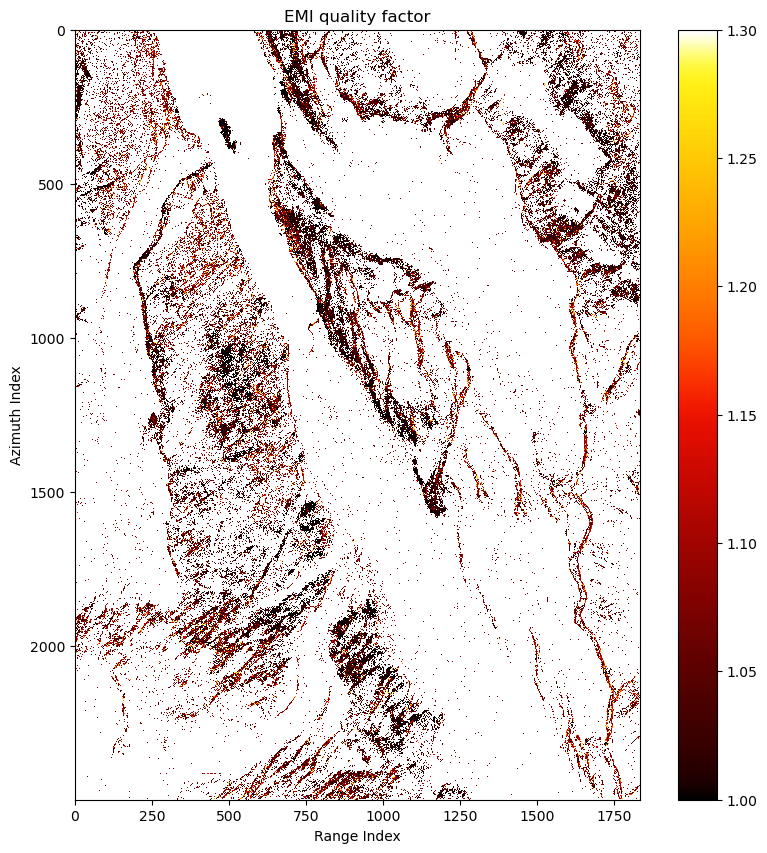

In [ ]:
emi_zarr = zarr.open('./pl/emi_quality.zarr','r')
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(emi_zarr[:],interpolation='nearest',vmin=1.0,vmax=1.3,cmap=colorcet.cm.fire)
ax.set(title='EMI quality factor',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
plt.show()

In [ ]:
#| export
@mc_logger
def ds_temp_coh(
    coh:str, # coherence matrix
    ph:str, # wrapped phase
    t_coh:str, # output, temporal coherence
    chunks:int=None, # number of point cloud chunk, same as coh by default
    cuda:bool=False, # if use cuda for processing, false by default
    processes=None, # use process for dask worker over thread, the default is False for cpu, only applied if cuda==False
    n_workers=None, # number of dask worker, the default is 1 for cpu, number of GPU for cuda
    threads_per_worker=None, # number of threads per dask worker, the default is 2 for cpu, only applied if cuda==False
    rmm_pool_size=0.9, # set the rmm pool size, only applied when cuda==True
    **dask_cluster_arg, # other dask local/cudalocal cluster args
):
    '''DS temporal coherence.
    '''
    coh_path = coh
    ph_path = ph
    t_coh_path = t_coh

    logger = logging.getLogger(__name__)
    coh_zarr = zarr.open(coh_path,mode='r'); logger.zarr_info(coh_path,coh_zarr)
    ph_zarr = zarr.open(ph_path,mode='r'); logger.zarr_info(ph_path,ph_zarr)

    if chunks is None: chunks = coh_zarr.chunks[0] 
    if cuda:
        Cluster = LocalCUDACluster; cluster_args= {
            'n_workers':n_workers,
            'rmm_pool_size':rmm_pool_size}
        cluster_args.update(dask_cluster_arg)
        xp = cp
    else:
        if processes is None: processes = False
        if n_workers is None: n_workers = 1
        if threads_per_worker is None: threads_per_worker = 2
        Cluster = LocalCluster; cluster_args = {'processes':processes, 'n_workers':n_workers, 'threads_per_worker':threads_per_worker}
        cluster_args.update(dask_cluster_arg)
        xp = np

    logger.info('starting dask local cluster.')
    with Cluster(**cluster_args) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')
        logger.dask_cluster_info(cluster)
        if cuda: client.run(cp.cuda.set_allocator, rmm_cupy_allocator)

        cpu_coh = da.from_zarr(coh_path, chunks=(chunks,*coh_zarr.shape[1:]))
        logger.darr_info('coh', cpu_coh)
        
        cpu_ph = da.from_zarr(ph_path, chunks=(chunks,*ph_zarr.shape[1:]))
        logger.darr_info('ph', cpu_ph)

        logger.info(f'Estimate temporal coherence for DS.')
        if cuda:
            coh = cpu_coh.map_blocks(cp.asarray)
            ph = cpu_ph.map_blocks(cp.asarray)
        else:
            coh = cpu_coh
            ph = cpu_ph

        coh_delayed = coh.to_delayed()
        coh_delayed = np.squeeze(coh_delayed,axis=(-2,-1))
        ph_delayed = ph.to_delayed()
        ph_delayed = np.squeeze(ph_delayed,axis=-1)
        t_coh_delayed = np.empty_like(coh_delayed,dtype=object)

        with np.nditer(coh_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as it:
            for block in it:
                idx = it.multi_index
                t_coh_delayed[idx] = delayed(mr.ds_temp_coh,pure=True,nout=1)(coh_delayed[idx],ph_delayed[idx])
                t_coh_delayed[idx] = da.from_delayed(t_coh_delayed[idx],shape=coh.blocks[idx].shape[0:1],meta=xp.array((),dtype=xp.float32))

            t_coh = da.block(t_coh_delayed.tolist())
    
        if cuda:
            cpu_t_coh = t_coh.map_blocks(cp.asnumpy)
        else:
            cpu_t_coh = t_coh
        logger.info(f'got temporal coherence t_coh.')
        logger.darr_info('t_coh', t_coh)

        logger.info('saving t_coh.')
        _cpu_t_coh = cpu_t_coh.to_zarr(t_coh_path,compute=False,overwrite=True)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_cpu_t_coh)
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

This function estimate the temporal coherence of DSs which is defined as [@ferrettiNewAlgorithmProcessing2011]:

$$\gamma = \frac{1}{N^2-N} \sum_{n=1}^{N} \sum_{k \neq n}^{N} e^{i\phi_{nk}} e^{-i(\theta_n-\theta_k)}$$

Where $\phi_{nk}$ is the phase of complex coherence matrix and $\theta_{n}$ is the phase after phase linking.

In [ ]:
ds_can_coh = './co/ds_can_coh.zarr'
ds_can_ph = './pl/ds_can_ph.zarr'
ds_can_t_coh = './pl/ds_can_t_coh.zarr'

In [ ]:
ds_temp_coh(ds_can_coh,ds_can_ph, ds_can_t_coh)
if is_cuda_available():
    ds_temp_coh(ds_can_coh,ds_can_ph, ds_can_t_coh,cuda=True)

2024-06-07 17:13:49 - log_args - INFO - running function: ds_temp_coh
2024-06-07 17:13:49 - log_args - INFO - fetching args:
2024-06-07 17:13:49 - log_args - INFO - coh = './co/ds_can_coh.zarr'
2024-06-07 17:13:49 - log_args - INFO - ph = './pl/ds_can_ph.zarr'
2024-06-07 17:13:49 - log_args - INFO - t_coh = './pl/ds_can_t_coh.zarr'
2024-06-07 17:13:49 - log_args - INFO - chunks = None
2024-06-07 17:13:49 - log_args - INFO - cuda = False
2024-06-07 17:13:49 - log_args - INFO - processes = None
2024-06-07 17:13:49 - log_args - INFO - n_workers = None
2024-06-07 17:13:49 - log_args - INFO - threads_per_worker = None
2024-06-07 17:13:49 - log_args - INFO - rmm_pool_size = 0.9
2024-06-07 17:13:49 - log_args - INFO - dask_cluster_arg = {}
2024-06-07 17:13:49 - log_args - INFO - fetching args done.
2024-06-07 17:13:49 - zarr_info - INFO - ./co/ds_can_coh.zarr zarray shape, chunks, dtype: (732727, 17, 17), (100000, 1, 1), complex64
2024-06-07 17:13:49 - zarr_info - INFO - ./pl/ds_can_ph.zarr z

2024-06-07 17:13:59,620 - distributed.worker - ERROR - std::bad_alloc: out_of_memory: RMM failure at:/opt/conda/conda-bld/work/include/rmm/mr/device/pool_memory_resource.hpp:424: Maximum pool size exceeded
Traceback (most recent call last):
  File "/users/kangl/miniforge3/envs/work/lib/python3.10/site-packages/distributed/utils.py", line 832, in wrapper
    return await func(*args, **kwargs)
  File "/users/kangl/miniforge3/envs/work/lib/python3.10/site-packages/distributed/worker.py", line 1873, in plugin_add
    result = plugin.setup(worker=self)
  File "/users/kangl/miniforge3/envs/work/lib/python3.10/site-packages/dask_cuda/plugins.py", line 95, in setup
    rmm.reinitialize(
  File "/users/kangl/miniforge3/envs/work/lib/python3.10/site-packages/rmm/rmm.py", line 81, in reinitialize
    mr._initialize(
  File "memory_resource.pyx", line 946, in rmm._lib.memory_resource._initialize
  File "memory_resource.pyx", line 1006, in rmm._lib.memory_resource._initialize
  File "memory_resourc

2024-06-07 17:13:59 - default_exception_handler - ERROR - Task exception was never retrieved
future: <Task finished name='Task-8384' coro=<_wrap_awaitable() done, defined at /users/kangl/miniforge3/envs/work/lib/python3.10/site-packages/distributed/deploy/spec.py:124> exception=RuntimeError('Worker failed to start.')>
Traceback (most recent call last):
  File "/users/kangl/miniforge3/envs/work/lib/python3.10/site-packages/distributed/core.py", line 664, in start
    await wait_for(self.start_unsafe(), timeout=timeout)
  File "/users/kangl/miniforge3/envs/work/lib/python3.10/site-packages/distributed/utils.py", line 1940, in wait_for
    return await asyncio.wait_for(fut, timeout)
  File "/users/kangl/miniforge3/envs/work/lib/python3.10/asyncio/tasks.py", line 408, in wait_for
    return await fut
  File "/users/kangl/miniforge3/envs/work/lib/python3.10/site-packages/distributed/worker.py", line 1473, in start_unsafe
    raise plugins_exceptions[0]
  File "/users/kangl/miniforge3/envs/w

In [ ]:
ds_can_gix = './shp/ds_can_gix.zarr'
t_coh = './pl/t_coh.zarr'
rslc_zarr = zarr.open('./raw/rslc.zarr/','r')
mc.pc2ras(ds_can_gix, ds_can_t_coh,t_coh,rslc_zarr.shape[:2])

2024-06-07 17:14:11 - log_args - INFO - running function: pc2ras
2024-06-07 17:14:11 - log_args - INFO - fetching args:
2024-06-07 17:14:11 - log_args - INFO - idx = './shp/ds_can_gix.zarr'
2024-06-07 17:14:11 - log_args - INFO - pc = './pl/ds_can_t_coh.zarr'
2024-06-07 17:14:11 - log_args - INFO - ras = './pl/t_coh.zarr'
2024-06-07 17:14:11 - log_args - INFO - shape = (2500, 1834)
2024-06-07 17:14:11 - log_args - INFO - chunks = (1000, 1000)
2024-06-07 17:14:11 - log_args - INFO - processes = False
2024-06-07 17:14:11 - log_args - INFO - n_workers = 2
2024-06-07 17:14:11 - log_args - INFO - threads_per_worker = 2
2024-06-07 17:14:11 - log_args - INFO - dask_cluster_arg = {}
2024-06-07 17:14:11 - log_args - INFO - fetching args done.
2024-06-07 17:14:11 - zarr_info - INFO - ./shp/ds_can_gix.zarr zarray shape, chunks, dtype: (732727, 2), (100000, 1), int32
2024-06-07 17:14:11 - pc2ras - INFO - loading gix into memory.
2024-06-07 17:14:11 - pc2ras - INFO - starting dask local cluster.
20

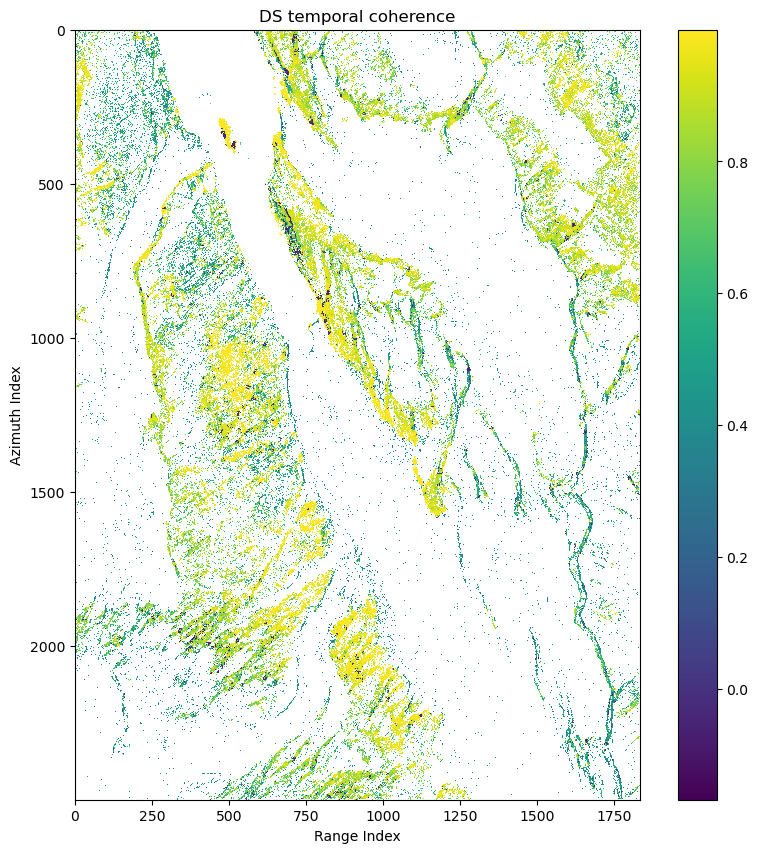

In [ ]:
t_coh_zarr = zarr.open(t_coh,'r')
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(t_coh_zarr[:],interpolation='nearest')
ax.set(title='DS temporal coherence',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()